In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
import tensorflow as tf
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
intermediate_dim = 512
latent_dim = 2

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

'max-min narmalize:將數值標準化成0-1'

'reshape data size:將圖片轉成一維(28, 28) -> (784)'

print(x_train.shape)
print(x_test.shape)

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1] 
    epsilon = tf.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\JohnnyHu\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 36us/step - loss: 197.1202 - val_loss: 172.2920
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 169.8033 - val_loss: 167.0338
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 165.3287 - val_loss: 163.7432
Epoch 4/50
60000/60000 [==============================] - 2s 29us/step - loss: 162.5663 - val_loss: 161.5197
Epoch 5/50
60000/60000 [==============================] - 2s 29us/step - loss: 160.5612 - val_loss: 159.8068
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 158.9688 - val_loss: 158.3581
Epoch 7/50
60000/60000 [==============================] - 2s 29us/step - loss: 157.7447 - val_loss: 157.6839
Epoch 8/50
60000/60000 [==============================] - 2s 29us/step - loss: 156.7366 - val_loss: 156.5144
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss

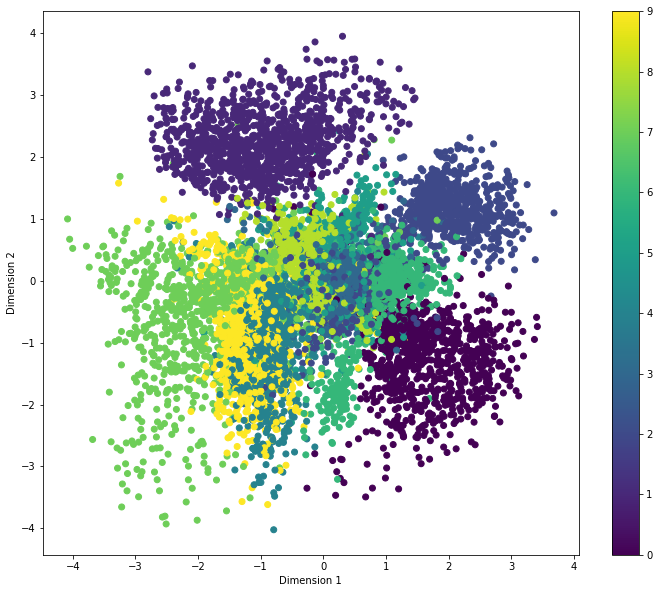

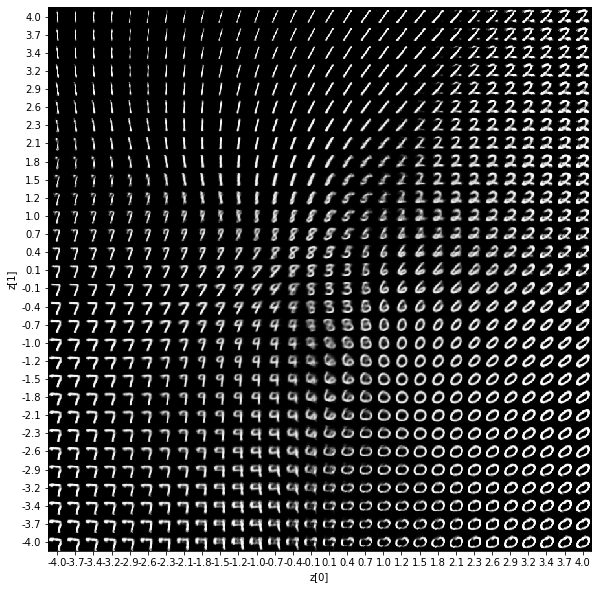

In [4]:
#####  encoder  #####
inputs = Input(shape=(  )) ## 輸入大小必須和圖片大小一樣
'請設計encoder的網路'


x = ...

#將x層的輸出接到z_mean, z_log_var
z_mean = Dense(2)(x)
z_log_var = Dense(2)(x)
#將z_mean, z_log_var層的輸出接到z層
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var]) 

encoder = Model(inputs, [z_mean, z_log_var, z]) # 建立encoder Model



#####  decoder  #####
latent_inputs = Input(shape=(   )) # decoder的輸入大小必須和encoder最後一層(z)輸出大小一樣
'請設計decoder的網路'


outputs = Dense(    , activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs) # 建立decoder Model



#####    vae    #####
outputs = decoder(encoder(inputs)[2]) #把encoder和decoder接起來

vae = Model(inputs, outputs) # 建立vae Model

#計算output與原圖(input)之間的crossentropy
reconstruction_loss = binary_crossentropy( ... , ... )
reconstruction_loss *= 800

#計算latent code的分佈與標準常態分佈的KL散度

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)

kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)

kl_loss *= -0.5 

#loss = crossentropy + KL_loss
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
#將計算後的loss加入Model內
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))

In [ ]:
def plot_results(*args,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder, x_test, y_test = args
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.savefig(filename)

    filename = os.path.join(model_name, "digits_over_latent.png")
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)

plot_results(encoder, decoder, x_test, y_test)